# Fastag Fraud Records Analysis

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import geopandas as gpd
from shapely.geometry import Point

file_path = 'data/FastagFraudDetection.csv'
data = pd.read_csv(file_path)
data.head()

   ---------------------------------------- 0.0/64.6 kB ? eta -:--:--
   ------------------- -------------------- 30.7/64.6 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 64.6/64.6 kB 687.8 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


,Transaction_ID,Timestamp,Vehicle_Type,FastagID,TollBoothID,Lane_Type,Vehicle_Dimensions,Transaction_Amount,Amount_paid,Geographical_Location,Vehicle_Speed,Vehicle_Plate_Number,Fraud_indicator
0,1,1/6/2023 11:20,Bus,FTG-001-ABC-121,A-101,Express,Large,350,120,"13.059816123454882, 77.77068662374292",65,KA11AB1234,Fraud
1,2,1/7/2023 14:55,Car,FTG-002-XYZ-451,B-102,Regular,Small,120,100,"13.059816123454882, 77.77068662374292",78,KA66CD5678,Fraud
2,3,1/8/2023 18:25,Motorcycle,NaN,D-104,Regular,Small,0,0,"13.059816123454882, 77.77068662374292",53,KA88EF9012,Not Fraud
3,4,1/9/2023 2:05,Truck,FTG-044-LMN-322,C-103,Regular,Large,350,120,"13.059816123454882, 77.77068662374292",92,KA11GH3456,Fraud
4,5,1/10/2023 6:35,Van,FTG-505-DEF-652,B-102,Express,Medium,140,100,"13.059816123454882, 77.77068662374292",60,KA44IJ6789,Fraud



## Data Preprocessing and Cleaning


In [24]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['Fraud_indicator'] = data['Fraud_indicator'].apply(lambda x: 1 if x == 'Fraud' else 0)
data['Geographical_Location'] = data['Geographical_Location'].apply(lambda x: tuple(map(float, x.split(','))))

data['FastagID'].fillna('UNKNOWN', inplace=True)

data['Year'] = data['Timestamp'].dt.year
data['Month'] = data['Timestamp'].dt.month
data['Day'] = data['Timestamp'].dt.day
data['Hour'] = data['Timestamp'].dt.hour
data['Minute'] = data['Timestamp'].dt.minute

data['Latitude'] = data['Geographical_Location'].apply(lambda x: x[0])
data['Longitude'] = data['Geographical_Location'].apply(lambda x: x[1])

data.drop(columns=['Timestamp', 'Geographical_Location'], inplace=True)

data.head()


,Transaction_ID,Vehicle_Type,FastagID,TollBoothID,Lane_Type,Vehicle_Dimensions,Transaction_Amount,Amount_paid,Vehicle_Speed,Vehicle_Plate_Number,Fraud_indicator,Year,Month,Day,Hour,Minute,Latitude,Longitude
0,1,Bus,FTG-001-ABC-121,A-101,Express,Large,350,120,65,KA11AB1234,1,2023,1,6,11,20,13.059816,77.770687
1,2,Car,FTG-002-XYZ-451,B-102,Regular,Small,120,100,78,KA66CD5678,1,2023,1,7,14,55,13.059816,77.770687
2,3,Motorcycle,UNKNOWN,D-104,Regular,Small,0,0,53,KA88EF9012,0,2023,1,8,18,25,13.059816,77.770687
3,4,Truck,FTG-044-LMN-322,C-103,Regular,Large,350,120,92,KA11GH3456,1,2023,1,9,2,5,13.059816,77.770687
4,5,Van,FTG-505-DEF-652,B-102,Express,Medium,140,100,60,KA44IJ6789,1,2023,1,10,6,35,13.059816,77.770687



## Exploratory Data Analysis (EDA)



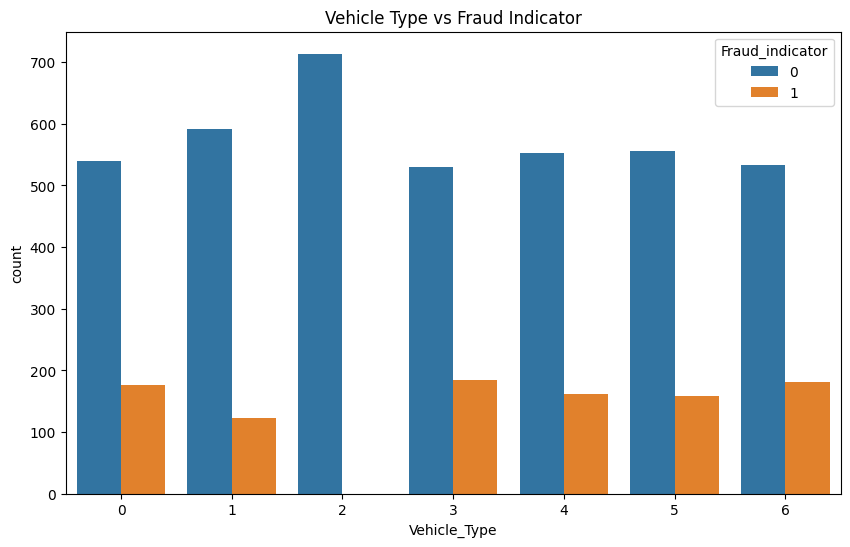

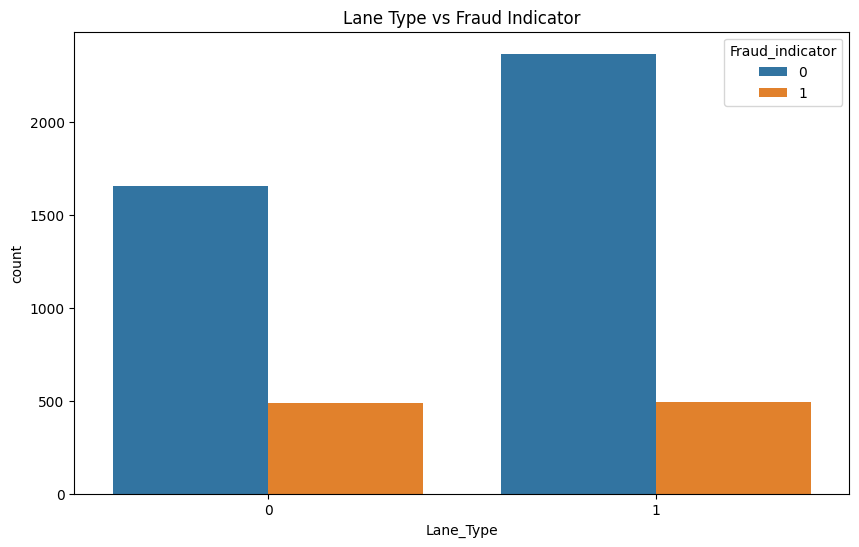

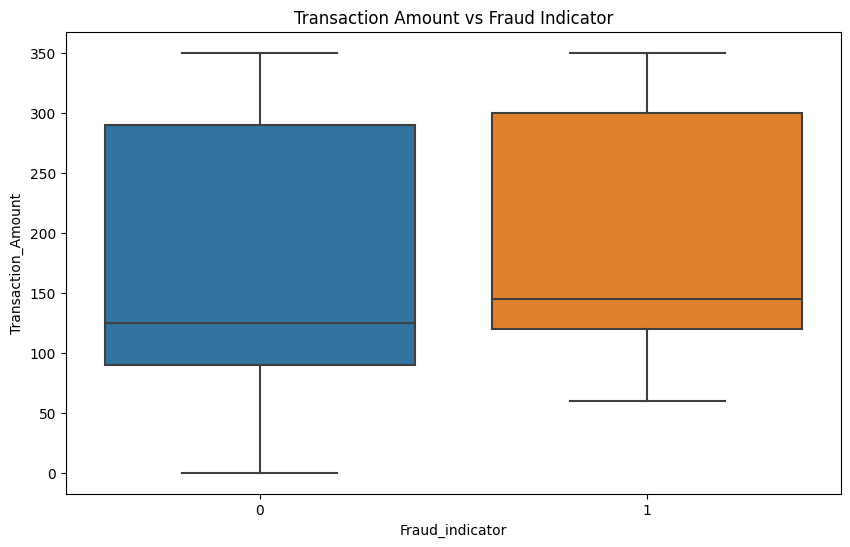

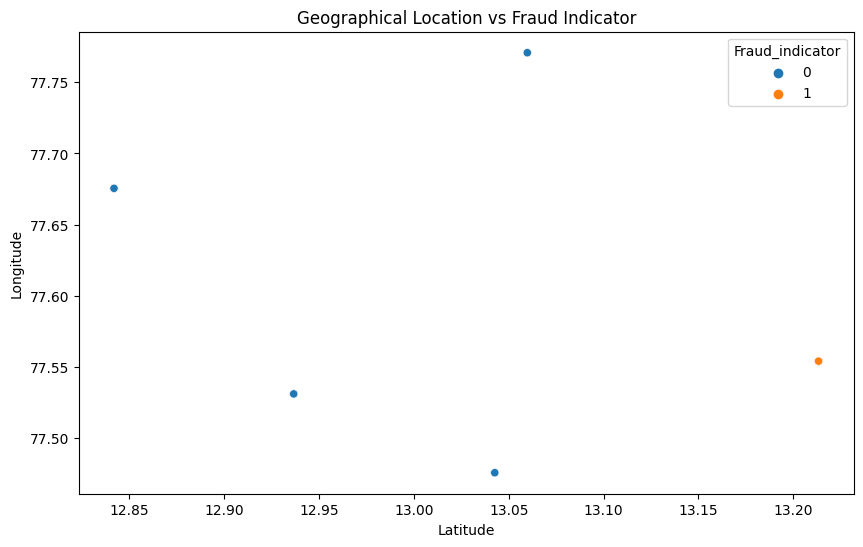

In [46]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Vehicle_Type', hue='Fraud_indicator', data=data)
plt.title('Vehicle Type vs Fraud Indicator')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='Lane_Type', hue='Fraud_indicator', data=data)
plt.title('Lane Type vs Fraud Indicator')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Fraud_indicator', y='Transaction_Amount', data=data)
plt.title('Transaction Amount vs Fraud Indicator')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Latitude', y='Longitude', hue='Fraud_indicator', data=data)
plt.title('Geographical Location vs Fraud Indicator')
plt.show()



## Feature Engineering



In [26]:

from sklearn.preprocessing import LabelEncoder

le_vehicle_type = LabelEncoder()
data['Vehicle_Type'] = le_vehicle_type.fit_transform(data['Vehicle_Type'])

le_lane_type = LabelEncoder()
data['Lane_Type'] = le_lane_type.fit_transform(data['Lane_Type'])

le_fastagid = LabelEncoder()
data['FastagID'] = le_fastagid.fit_transform(data['FastagID'])

le_vehicle_dimensions = LabelEncoder()
data['Vehicle_Dimensions'] = le_vehicle_dimensions.fit_transform(data['Vehicle_Dimensions'])

X = data.drop(columns=['Transaction_ID', 'Fraud_indicator', 'Vehicle_Plate_Number', 'TollBoothID'])
y = data['Fraud_indicator']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



## Model Training and Evaluation


Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1173
           1       1.00      0.90      0.95       327

    accuracy                           0.98      1500
   macro avg       0.99      0.95      0.97      1500
weighted avg       0.98      0.98      0.98      1500

Confusion Matrix:
[[1173    0]
 [  34  293]]


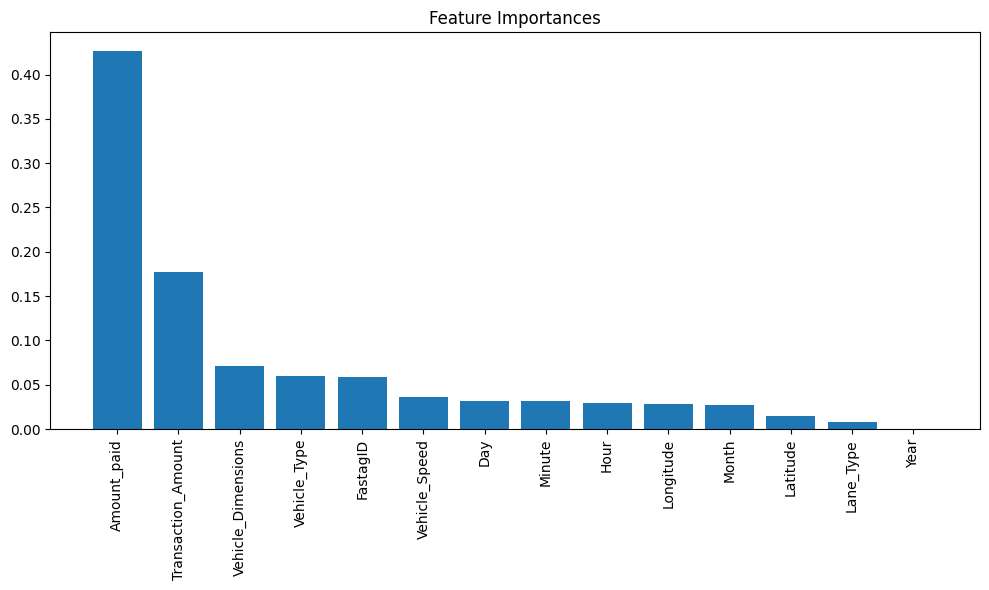

In [27]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

importances = clf.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.tight_layout()
plt.show()

## Correlation Heatmap

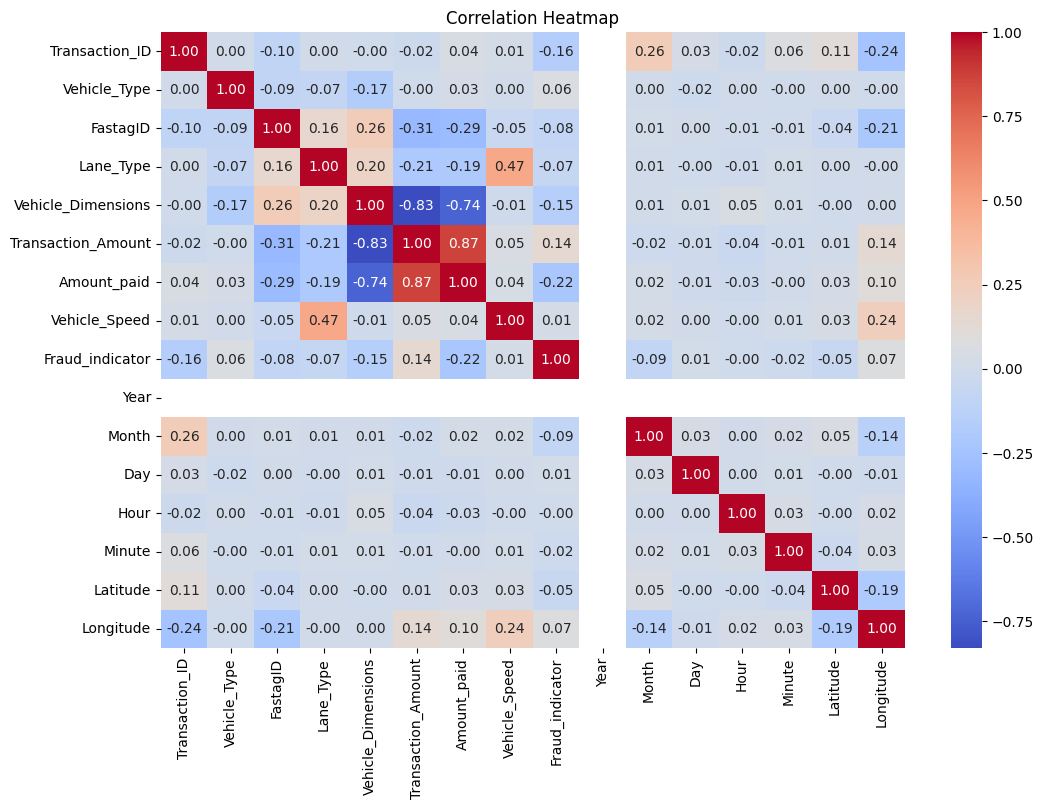

In [28]:
plt.figure(figsize=(12, 8))
numeric_data = data.select_dtypes(include=[np.number])
corr_matrix = numeric_data.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


##  Time Series Analysis of Transactions

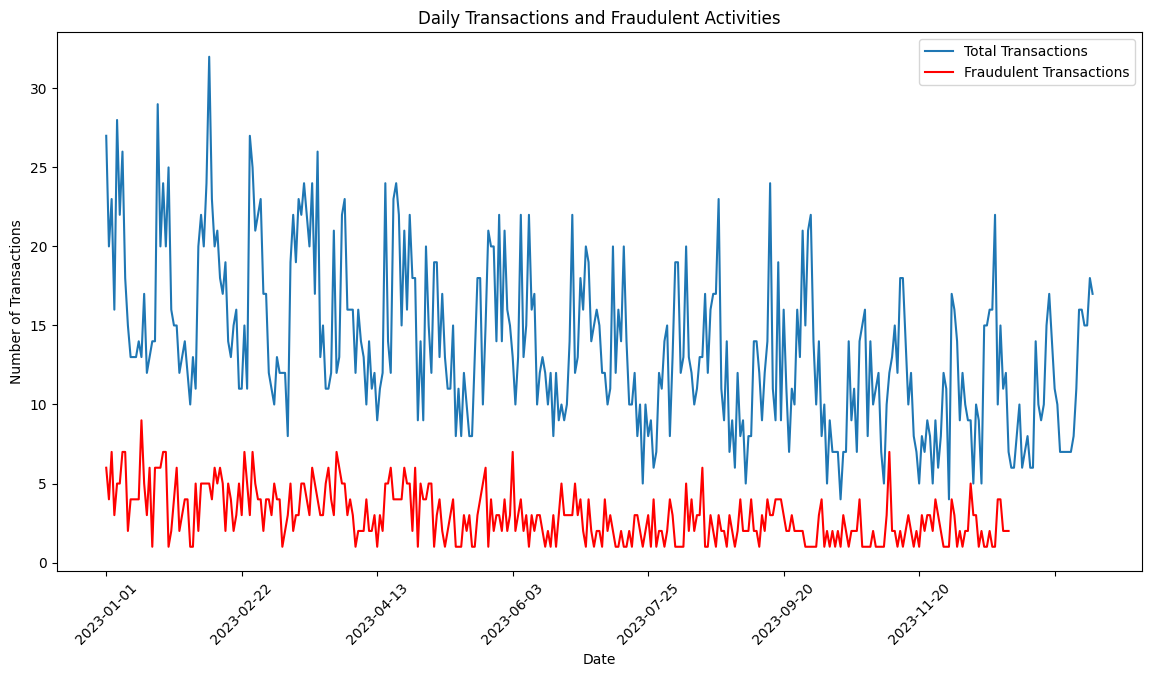

In [29]:
data['Date'] = data.apply(lambda row: f"{row['Year']}-{row['Month']:02d}-{row['Day']:02d}", axis=1)
daily_transactions = data.groupby('Date').size()
daily_frauds = data[data['Fraud_indicator'] == 1].groupby('Date').size()

plt.figure(figsize=(14, 7))
daily_transactions.plot(label='Total Transactions')
daily_frauds.plot(label='Fraudulent Transactions', color='red')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.title('Daily Transactions and Fraudulent Activities')
plt.legend()
plt.xticks(rotation=45)
plt.show()


## Vehicle Speed Distribution by Vehicle Type

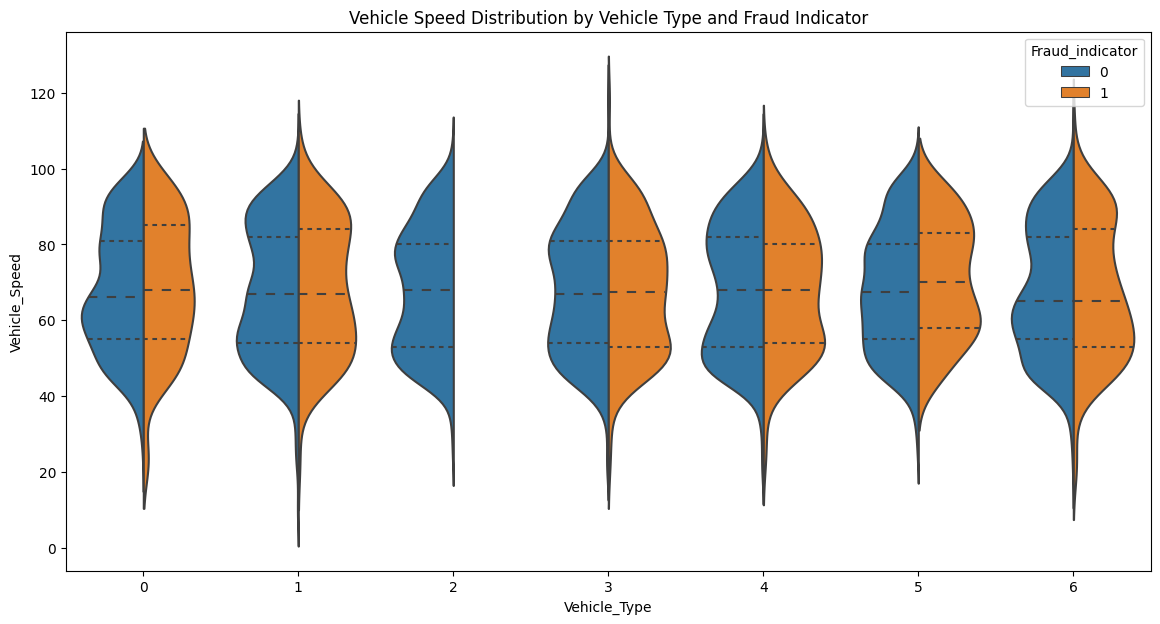

In [30]:
plt.figure(figsize=(14, 7))
sns.violinplot(x='Vehicle_Type', y='Vehicle_Speed', hue='Fraud_indicator', data=data, split=True, inner='quart')
plt.title('Vehicle Speed Distribution by Vehicle Type and Fraud Indicator')
plt.show()


## Modeling with Hyperparameter Tuning

In [45]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_clf = grid_search.best_estimator_
y_pred_best = best_clf.predict(X_test)

print('Best Parameters:')
print(grid_search.best_params_)

print('Classification Report with Best Parameters:')
print(classification_report(y_test, y_pred_best))

print('Confusion Matrix with Best Parameters:')
print(confusion_matrix(y_test, y_pred_best))


Fitting 3 folds for each of 648 candidates, totalling 1944 fits


C:\Users\Debjit Mandal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
495 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Debjit Mandal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Debjit Mandal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2k

Best Parameters:
{'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Classification Report with Best Parameters:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1173
           1       1.00      0.92      0.96       327

    accuracy                           0.98      1500
   macro avg       0.99      0.96      0.97      1500
weighted avg       0.98      0.98      0.98      1500

Confusion Matrix with Best Parameters:
[[1173    0]
 [  27  300]]



## Summary
This notebook provides an in-depth analysis of the Fastag fraud detection dataset. The key steps undertaken in this analysis include:

1. **Data Preprocessing and Cleaning**: We handled missing values, converted categorical variables, and extracted relevant features from the timestamp and geographical location data.
2. **Exploratory Data Analysis (EDA)**: Various visualizations were used to understand the distribution and relationships of different features with respect to fraudulent activities.
3. **Feature Engineering**: Categorical variables were encoded, and the data was prepared for machine learning modeling.
4. **Model Training and Evaluation**: A RandomForest classifier was trained, and its performance was evaluated using classification reports and feature importance analysis.
5. **Advanced Visualization and Analysis**: Additional visualizations such as correlation heatmaps, time series analysis, and geospatial analysis provided further insights into the data.
6. **Modeling with Hyperparameter Tuning**: Hyperparameter tuning was performed to improve the model performance.

## Conclusion
Through the analysis, several important observations were made:
- Certain vehicle types and lane types have a higher incidence of fraudulent transactions.
- There are significant differences in transaction amounts and vehicle speeds between fraudulent and non-fraudulent transactions.
- Geospatial analysis highlighted specific locations with higher instances of fraud, indicating potential areas for targeted monitoring and intervention.
- Hyperparameter tuning improved the model's performance, demonstrating the importance of optimizing model parameters for better fraud detection.

Overall, this comprehensive analysis provides valuable insights that can be used to enhance the effectiveness of fraud detection systems for the Fastag electronic toll collection system in India. Future work could involve exploring more advanced machine learning models and incorporating additional data sources for even better accuracy and detection capabilities.
